In [269]:
import re
import pandas as pd
import tqdm, time

#### 1. generate a txt file with format chrN:12345678-12345678 using chromosome and hg19_position from file all_variants_and_proxies.csv

In [3]:
df = pd.read_csv('~/Documents/Materials/iron/all_variants_and_proxies.csv')
# df['format'] = 'chr'+df.chromosome.astype(str)+':'+df.hg19_position.astype(str)+'-'+df.hg19_position.astype(str)
# df['format'].to_csv('~/Documents/Projects/iron/variants_hg19.txt', index=False) 

#### 2. convert hg19 coordinates to hg38 coordinates using liftover tool: 
https://genome.ucsc.edu/cgi-bin/hgLiftOver

#### 3. rename the file downloaded from the tool as variants_hg19.bed and then add it to all_variants_and_proxies.csv

In [7]:
df0 = pd.read_csv('~/Documents/Materials/iron/variants_hg38.bed', header=None) 
df['hg38_position'] = df0[0].str.extract('\:(\d+)\-') 
df.to_csv('~/Documents/Materials/iron/all_variants_and_proxies.csv', index=False)

#### 4. scrape off head and AF from https://results.finngen.fi/ using rsid
backend of finngen dashboard: https://github.com/FINNGEN/saige-pipelines/blob/master/wdl/gwas/saige.json

e.g. Given rs1961437,

```head = '22:37114993:A:G (rs1961437)'``` 

```str_af = 'AF 9.1e-1(ranges from 9.1e-1 to 9.1e-1 across all phenotypes)'```

```af = 0.91```

In [33]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
browser = webdriver.Chrome(Service('/Users/feiwang/Documents/Projects/chromedriver'))
browser.get('https://results.finngen.fi/')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  after removing the cwd from sys.path.


In [160]:
finngen_format_list, finngen_af_list = [], []

for i in tqdm.tqdm(df.rsid.tolist()):
#     browser.get('https://results.finngen.fi/variant/'+1:22227885-T-C)
    # there are 9 SNPs without rsid in the file
    if type(i) == float:
        finngen_format_list.append('id isna')
        finngen_eaf_list.append('id isna')
    else:
        browser.find_element(By.XPATH, '//*[@id="navbar-searchbox-input"]').send_keys(i)
        browser.find_element(By.XPATH, '//*[@id="navbar-searchbox-input"]').send_keys(Keys.RETURN)
        time.sleep(5)
        try:
            head = browser.find_element(By.XPATH, '/html/body/div/div[1]/div/h1').text
        except:
    #         err = browser.find_element_by_xpath('//*[@id="reactEntry"]/div/div/div/p[1]').text
            head = 'id notfound'
        if head == 'id notfound':
            eaf = 'id notfound'
        else:
            try:
                str_af = browser.find_element(By.XPATH, '//*[@id="maf-range"]/p').text
                af = float(re.findall('AF ([\d|\.|e|\-]+)\(ranges', str_eaf)[0])
            except:
                af = 'eaf notfound'

        finngen_format_list.append(head)
        finngen_af_list.append(af)
        time.sleep(1)

  0%|          | 0/1039 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
100%|██████████| 1039/1039 [1:50:57<00:00

In [169]:
df['finn_format'] = finngen_format_list
df['finn_af'] = finngen_af_list

In [198]:
df['finn_rsid'] = df.finn_format.str.extract(' \((rs\d+)\)')
df['finn_ref'] = df.finn_format.str.extract(':(\w+):\w+ \(')
df['finn_alt'] = df.finn_format.str.extract(':\w+:(\w+) \(')

In [199]:
df['match'] = df.finn_rsid == df.rsid

In [204]:
for i, row in df[(df.match == False)&(df.finn_rsid.isna())&(df.finn_format != 'id notfound')].iterrows():
    id_list = re.findall('(rs\d+)',row.finn_format)
    if row.rsid in id_list:
        df.loc[i,'finn_rsid'] = row.rsid
        df.loc[i,'match'] = True

In [245]:
print(len(df[df.match == False]),'cannot be found unfortunately')
print(len(df)-len(df[df.match == False]),'were found successfully')

514 cannot be found unfortunately
2672 were found successfully


#### 5. create a list of format that can be recognized in finngen sandbox

In [241]:
df['finn_hg38'] = df.finn_format.str.extract('\d{1,2}\:(\d+)\:\w+\:')
df['sandbox_format'] = 'chr'+df.chromosome.astype(str)+'_'+df.finn_hg38+'_'+df.finn_ref+'_'+df.finn_alt
df.to_csv('~/Documents/Materials/iron/all_variants_and_proxies.csv', index=False)

#### 6. obtain phecode_map from PheWAS package in R
See phecode_map.R for detail
#### 7. label if a PheCode is sex-specified
Download sex-specified PheCode dictionary from https://phewascatalog.org/files/phecode_definitions1.2.csv.zip

In [411]:
phecode_map = pd.read_csv('~/Documents/Materials/iron/phecode_map.csv') 
phecode_def = pd.read_csv('~/Documents/Materials/iron/phecode_definitions1.2.csv') 
phecode_list = phecode_map.phecode.unique().tolist()
phecode_dict = pd.DataFrame({'phecode':phecode_list})
phecode_dict = phecode_dict.merge(phecode_def[['phecode','sex']], 'left')

In [416]:
phecode_sex = phecode_dict[(~phecode_dict.sex.isna())&(phecode_dict.sex != 'Both')]
# in total 166 sex-specified phecodes
phecode_sex.to_csv('~/Documents/Materials/iron/phecode_sex.csv', index=None)

#### 8. upload the files to green bucket: 
https://console.cloud.google.com/storage/browser/fg-production-sandbox-6_green

gsutil cp ~/Documents/Materials/iron/all_variants_and_proxies.csv gs://fg-production-sandbox-6_green/FeiyiWang

gsutil cp ~/Documents/Materials/iron/phecode_map.csv gs://fg-production-sandbox-6_green/FeiyiWang

gsutil cp ~/Documents/Materials/iron/phecode_sex.csv gs://fg-production-sandbox-6_green/FeiyiWang

In [430]:
import statsmodels.api as sm
import researchpy as rp
from sklearn.linear_model import LogisticRegression

In [465]:
def get_summary(X, y, model):
    """
    :param model: a model for training
    :param X: a DataFrame of inputs
    :param y: a Series of output
    :return: a DataFrame of key statistics
    """
    model = model.fit(X, y)
    coef = np.append(model.intercept_, model.coef_)
    X_matrix = np.append(np.ones((len(X), 1)), X, axis=1)
    y_hat = model.predict(X)
    degree_of_freedom = X_matrix.shape[0] - X_matrix.shape[1]
    MSE = (sum((y_hat - y) ** 2)) / degree_of_freedom
    var_coef = MSE * (np.linalg.inv(np.dot(X_matrix.T, X_matrix)).diagonal())
    std_err_coef = np.sqrt(var_coef)
    t_stat_coef = coef / std_err_coef
    p_values_coef = [2 * (1 - stats.t.cdf(np.abs(i), degree_of_freedom)) for i in t_stat_coef]
    t_half_alpha = stats.t.ppf(1 - 0.025, degree_of_freedom)
    ci1_coef = [beta - t_half_alpha * se_beta for beta, se_beta in zip(coef, std_err_coef)]
    ci2_coef = [beta + t_half_alpha * se_beta for beta, se_beta in zip(coef, std_err_coef)]
    summary_df = pd.DataFrame({
        'coef': np.round(coef, 4),
        'std_err': np.round(std_err_coef, 3),
        't_stat': np.round(t_stat_coef, 3),
        'p_value': np.round(p_values_coef, 3),
        'ci_1': np.round(ci1_coef, 3),
        'ci_2': np.round(ci2_coef, 3),
    }, index=['const'] + X.columns.tolist())
    return summary_df

In [471]:
data = pd.read_csv('https://stats.idre.ucla.edu/stat/data/binary.csv')
data

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
...,...,...,...,...
395,0,620,4.00,2
396,0,560,3.04,3
397,0,460,2.63,2
398,0,700,3.65,2


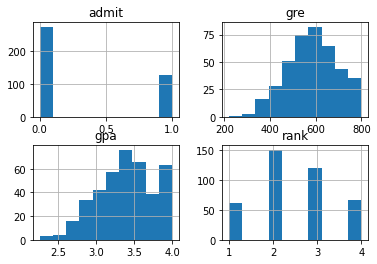

In [472]:
# plot all of the columns
data.hist()
plt.show()

In [473]:
data['rank'] = data['rank'].astype('category') 

In [457]:
data.dtypes

admit       int64
gre         int64
gpa       float64
rank     category
dtype: object

In [458]:
data.describe()

,admit,gre,gpa
count,400.000000,400.000000,400.000000
mean,0.317500,587.700000,3.389900
std,0.466087,115.516536,0.380567
min,0.000000,220.000000,2.260000
25%,0.000000,520.000000,3.130000
50%,0.000000,580.000000,3.395000
75%,1.000000,660.000000,3.670000
max,1.000000,800.000000,4.000000


In [466]:
get_summary(data[['gre','gpa','rank']], data.admit, LogisticRegression())

,coef,std_err,t_stat,p_value,ci_1,ci_2
const,-3.2666,0.265,-12.321,0.0,-3.788,-2.745
gre,0.0024,0.000,9.287,0.0,0.002,0.003
gpa,0.7012,0.077,9.053,0.0,0.549,0.853
rank,-0.5499,0.029,-18.938,0.0,-0.607,-0.493


In [474]:
get_summary(data[['gre','gpa','rank']], data.admit, LogisticRegression(penalty='none'))

,coef,std_err,t_stat,p_value,ci_1,ci_2
const,-3.4496,0.266,-12.956,0.0,-3.973,-2.926
gre,0.0023,0.000,8.897,0.0,0.002,0.003
gpa,0.7771,0.078,9.990,0.0,0.624,0.930
rank,-0.5600,0.029,-19.206,0.0,-0.617,-0.503


In [464]:
X = sm.add_constant(data[['gre','gpa','rank']])
est = sm.Logit(data.admit, X).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.574302
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Thu, 10 Mar 2022   Pseudo R-squ.:                 0.08107
Time:                        16:45:47   Log-Likelihood:                -229.72
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 8.207e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4495      1.133     -3.045      0.002      -5.670      -1.229
gre            0.0023      0.

In [475]:
# the results are as same as those in R
X = sm.add_constant(pd.concat([
    data[['gre','gpa']], pd.get_dummies(data['rank'], drop_first=True)
], axis=1))
est = sm.Logit(data.admit, X).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Thu, 10 Mar 2022   Pseudo R-squ.:                 0.08292
Time:                        16:58:24   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 7.578e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9900      1.140     -3.500      0.000      -6.224      -1.756
gre            0.0023      0.

What tripped me up:

- disable sklearn regularization LogisticRegression(C=1e9)
- add statsmodels intercept sm.Logit(y,sm.add_constant(X)) OR disable sklearn intercept LogisticRegression(C=1e9,fit_intercept=False)
- sklearn returns probability for each class so model_sklearn.predict_proba(X)[:,1] == model_statsmodel.predict(X)
- Use of predict fucntion model_sklearn.predict(X) == (model_statsmodel.predict(X)>0.5).astype(int)

I'm now seeing the same results in both libraries.

In [478]:
# But still the results are different
X = pd.concat([
    data[['gre','gpa']], pd.get_dummies(data['rank'], drop_first=True)
], axis=1)
get_summary(X, data.admit, LogisticRegression(penalty='none'))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,coef,std_err,t_stat,p_value,ci_1,ci_2
const,-3.9637,0.265,-14.981,0.0,-4.484,-3.444
gre,0.0024,0.000,9.148,0.0,0.002,0.003
gpa,0.7771,0.078,9.918,0.0,0.623,0.931
2,-0.6478,0.083,-7.810,0.0,-0.811,-0.485
3,-1.3527,0.086,-15.720,0.0,-1.522,-1.184
4,-1.5690,0.097,-16.149,0.0,-1.760,-1.378


https://www.pythonfordatascience.org/mixed-effects-regression-python/

In [427]:
df = pd.read_csv("http://www-personal.umich.edu/~bwest/rat_pup.dat", sep = "\t")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pup_id     322 non-null    int64  
 1   weight     322 non-null    float64
 2   sex        322 non-null    object 
 3   litter     322 non-null    int64  
 4   litsize    322 non-null    int64  
 5   treatment  322 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 15.2+ KB


In [428]:
df

,pup_id,weight,sex,litter,litsize,treatment
0,1,6.60,Male,1,12,Control
1,2,7.40,Male,1,12,Control
2,3,7.15,Male,1,12,Control
3,4,7.24,Male,1,12,Control
4,5,7.10,Male,1,12,Control
...,...,...,...,...,...,...
317,318,5.69,Male,27,9,High
318,319,6.36,Male,27,9,High
319,320,5.93,Female,27,9,High
320,321,5.74,Female,27,9,High


In [432]:
rp.summary_cont(df.groupby(["treatment", "sex"])["weight"])

N    Mean      SD      SE  95% Conf.  Interval
treatment sex                                                    
Control   Female  54  6.1161  0.6851  0.0932     5.9291    6.3031
          Male    77  6.4710  0.7538  0.0859     6.3000    6.6421
High      Female  32  5.8516  0.6002  0.1061     5.6352    6.0680
          Male    33  5.9185  0.6909  0.1203     5.6735    6.1635
Low       Female  65  5.8375  0.4505  0.0559     5.7259    5.9492
          Male    61  6.0251  0.3803  0.0487     5.9277    6.1225

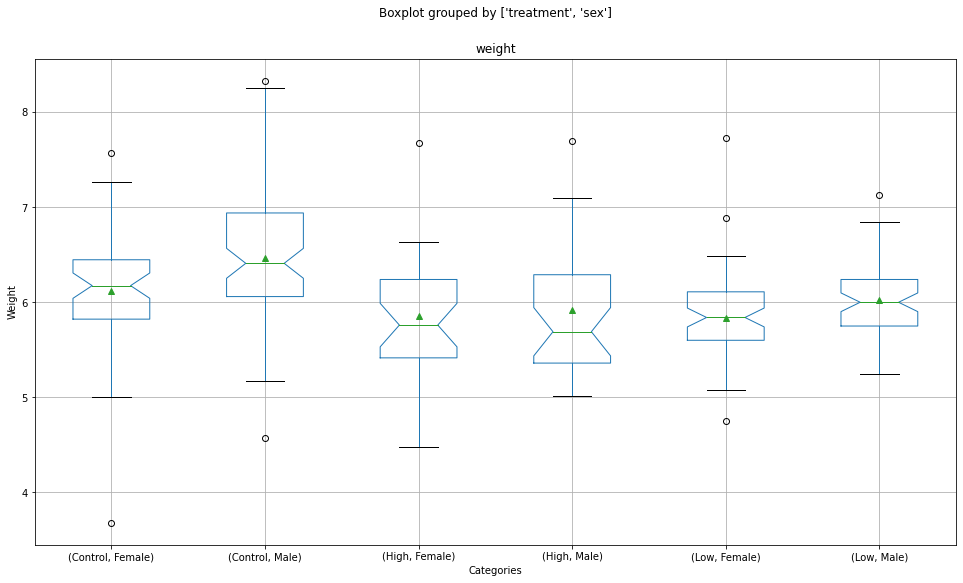

In [436]:
boxplot = df.boxplot(["weight"], by = ["treatment", "sex"],
                     figsize = (16, 9),
                     showmeans = True,
                     notch = True)
boxplot.set_xlabel("Categories")
boxplot.set_ylabel("Weight")
ax = boxplot

In [437]:
import statsmodels.formula.api as smf

### Random Intercept Model

In [440]:
model = smf.mixedlm("weight ~ litsize + C(treatment) + C(sex, Treatment('Male')) + C(treatment):C(sex, Treatment('Male'))",
                    df, groups= "litter").fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Mixed Linear Model Regression Results
===================================================================================================
Model:                            MixedLM               Dependent Variable:               weight   
No. Observations:                 322                   Method:                           REML     
No. Groups:                       27                    Scale:                            0.1635   
Min. group size:                  2                     Log-Likelihood:                   -200.5522
Max. group size:                  18                    Converged:                        Yes      
Mean group size:                  11.9                                                             
---------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                                                 8.323    0.273 30.447 0.000  7.788  8.859
C(treatment)[T.High]                                     -0.906    0.192 -4.727 0.000 -1.282 -0.530
C(treatment)[T.Low]                                      -0.467    0.158 -2.952 0.003 -0.777 -0.157
C(sex, Treatment('Male'))[T.Female]                      -0.412    0.073 -5.625 0.000 -0.555 -0.268
C(treatment)[T.High]:C(sex, Treatment('Male'))[T.Female]  0.107    0.132  0.811 0.417 -0.151  0.366
C(treatment)[T.Low]:C(sex, Treatment('Male'))[T.Female]   0.084    0.106  0.794 0.427 -0.123  0.291
litsize                                                  -0.128    0.019 -6.845 0.000 -0.165 -0.092
litter Var                                                0.097    0.084                           
===================================================================================================

"""

In [441]:
# Random Intercept Model w/out Interaction Term
model = smf.mixedlm("weight ~ litsize + C(treatment) + C(sex, Treatment('Male'))", 
                    df, groups= "litter").fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                     MixedLM        Dependent Variable:        weight   
No. Observations:          322            Method:                    REML     
No. Groups:                27             Scale:                     0.1628   
Min. group size:           2              Log-Likelihood:            -198.4997
Max. group size:           18             Converged:                 Yes      
Mean group size:           11.9                                               
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            8.310    0.274 30.355 0.000  7.773  8.846
C(treatment)[T.High]                -0.859    0.182 -4.722 0.000 -1.215 -0.502
C(treatment)[T.Low]                 -0.429    0.150 -2.849 0.004 -0.723 -0.134
C(sex, Treatment('Male'))[T.Female] -0.359    0.048 -7.540 0.000 -0.452 -0.266
litsize                             -0.129    0.019 -6.863 0.000 -0.166 -0.092
litter Var                           0.097    0.085                           
==============================================================================

"""

### Random Slope Model

In [442]:
# Random Slope Model: Random intercepts and slopes are independent
model2 = smf.mixedlm("weight ~ litsize + C(treatment) + C(sex)", df, groups= "litter",
                     vc_formula = {"sex" : "0 + C(sex)"}).fit()
model2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM   Dependent Variable:   weight   
No. Observations:     322       Method:               REML     
No. Groups:           27        Scale:                0.1565   
Min. group size:      2         Log-Likelihood:       -205.7020
Max. group size:      18        Converged:            Yes      
Mean group size:      11.9                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             7.874    0.229 34.380 0.000  7.425  8.323
C(treatment)[T.High] -0.839    0.144 -5.827 0.000 -1.121 -0.557
C(treatment)[T.Low]  -0.411    0.116 -3.526 0.000 -0.639 -0.182
C(sex)[T.Male]        0.356    0.102  3.508 0.000  0.157  0.555
litsize              -0.124    0.016 -7.915 0.000 -0.155 -0.093
sex Var               0.104    0.076                           
===============================================================

"""

In [443]:
# Random Slope Model: Random intercepts and slopes are correlated
model2 = smf.mixedlm("weight ~ litsize + C(treatment) + C(sex)", df, groups= "litter",
                     re_formula = "1 + C(sex)").fit()
model2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                 MixedLM      Dependent Variable:      weight   
No. Observations:      322          Method:                  REML     
No. Groups:            27           Scale:                   0.1601   
Min. group size:       2            Log-Likelihood:          -196.3946
Max. group size:       18           Converged:               Yes      
Mean group size:       11.9                                           
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    7.806    0.263 29.672 0.000  7.291  8.322
C(treatment)[T.High]        -0.778    0.172 -4.523 0.000 -1.116 -0.441
C(treatment)[T.Low]         -0.387    0.137 -2.821 0.005 -0.656 -0.118
C(sex)[T.Male]               0.359    0.053  6.783 0.000  0.255  0.463
litsize                     -0.120    0.018 -6.637 0.000 -0.155 -0.084
litter Var                   0.063    0.074                           
litter x C(sex)[T.Male] Cov  0.028    0.044                           
C(sex)[T.Male] Var           0.013    0.062                           
======================================================================

"""

In [448]:
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Residuals')

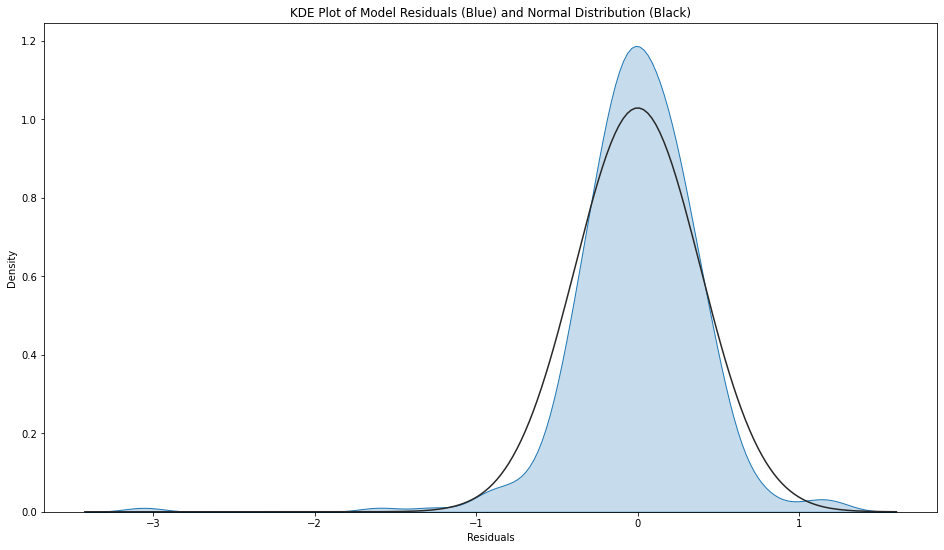

In [452]:
fig = plt.figure(figsize = (16, 9))
ax = sns.distplot(model.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)
ax.set_title("KDE Plot of Model Residuals (Blue) and Normal Distribution (Black)")
ax.set_xlabel("Residuals")

Text(0.5, 1.0, 'Q-Q Plot')

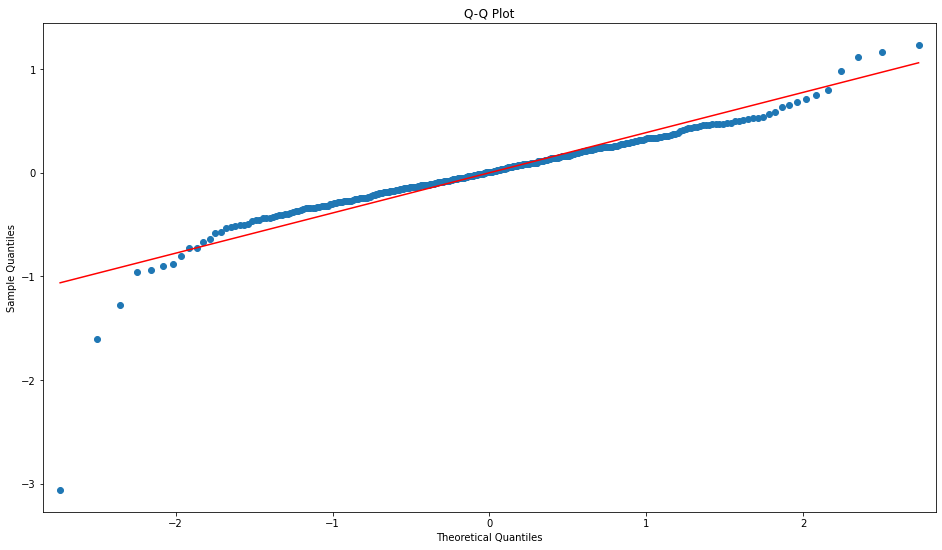

In [453]:
## Q-Q PLot

fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)
sm.qqplot(model.resid, dist = stats.norm, line = 's', ax = ax)
ax.set_title("Q-Q Plot")